In [1]:
import numpy as np
import xarray as xr
#from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
from xgcm import Grid
from matplotlib import colors, ticker, cm
from xhistogram.xarray import histogram 
from matplotlib import colors as cols
import pandas as pd

In [2]:
import matplotlib 
font = {'family' : 'sans-serif',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
horispace = 1e3
f =  -1.1E-04

vortband01 = np.linspace(-4, 4, 120)
strainband01 = np.linspace(0, 4, 120)
binbox01 =  (vortband01[1]-vortband01[0])*(strainband01[1]-strainband01[0])

In [4]:
def histTimeSep(vort, strain, timeNum, vortband01, strainband01):
    ### calculate vorticity-strain jpdf given vorticity and strain and specified time range, and bins for both variable
    vortSnap = vort.isel(time=0).load()
    strainSnap = strain.isel(time=0).load()
    hist = histogram(vortSnap.rename('vort'), strainSnap.rename('strain'), dim = ['i','j'] , bins=[vortband01,strainband01])
    hist.load()
    for tid in range(1, timeNum):
        vortSnap = vort.isel(time = tid).load()
        strainSnap = strain.isel(time = tid).load()
        histTemp = histogram(vortSnap.rename('vort'), strainSnap.rename('strain'), dim = ['i','j'] , bins=[vortband01,strainband01])
        histTemp.load()
        hist = hist+histTemp
    hist = hist/timeNum
    return hist

In [5]:
def vortCal(field_u, field_v, ds, grid, f):
    ### calculate normalized vorticity, strain and divergence given u (ds[field_u]) and v (ds[field_v])
    u_transport = grid.interp(ds[field_u],'X', boundary='extend')*ds.DYG 
    v_transport = grid.interp(ds[field_v],'Y', boundary='extend')*ds.DXG 
    div_uv = (grid.diff(u_transport, 'X', boundary='extend') + grid.diff(v_transport, 'Y', boundary='extend')) / ds.RAC
    
    u_cor = grid.interp(ds[field_u],'X', boundary='extend')*ds.DXC
    v_cor = grid.interp(ds[field_v],'Y', boundary='extend')*ds.DYC
    zeta = grid.interp(grid.interp(-grid.diff(u_cor, 'Y', boundary='extend') + grid.diff(v_cor, 'X', boundary='extend'), 'X', boundary='extend'), 'Y', boundary='extend')/ds.RAC

    strain1 = (grid.diff(u_transport, 'X', boundary='extend') - grid.diff(v_transport, 'Y', boundary='extend')) / ds.RAC
    strain2 = grid.interp(grid.interp(grid.diff(u_cor, 'Y', boundary='extend') + grid.diff(v_cor, 'X', boundary='extend'), 'X', boundary='extend'), 'Y', boundary='extend')/ds.RAC
    strain = (strain1**2 + strain2**2)**0.5
    
    zeta_01 = (zeta/f).rename('vort1_0')
    strain_01 = abs(strain/f).rename('strain1_0')
    div_01 = (div_uv/abs(f)).rename('div1_0')
    
    return zeta_01, strain_01, div_01

In [6]:
def vortCal_diff(field_u1, field_u2, field_v1, field_v2, ds, grid, f):
    ### calculate normalized vorticity, strain and divergence given difference of two u fields (ds[field_u1] - ds[field_u2]) and two v fields (ds[field_v1] - ds[field_v2])
    u_transport = grid.interp(ds[field_u1] - ds[field_u2],'X', boundary='extend')*ds.DYG 
    v_transport = grid.interp(ds[field_v1] - ds[field_v2],'Y', boundary='extend')*ds.DXG 
    div_uv = (grid.diff(u_transport, 'X', boundary='extend') + grid.diff(v_transport, 'Y', boundary='extend')) / ds.RAC
    
    u_cor = grid.interp(ds[field_u1] - ds[field_u2],'X', boundary='extend')*ds.DXC
    v_cor = grid.interp(ds[field_v1] - ds[field_v2],'Y', boundary='extend')*ds.DYC
    zeta = grid.interp(grid.interp(-grid.diff(u_cor, 'Y', boundary='extend') + grid.diff(v_cor, 'X', boundary='extend'), 'X', boundary='extend'), 'Y', boundary='extend')/ds.RAC

    strain1 = (grid.diff(u_transport, 'X', boundary='extend') - grid.diff(v_transport, 'Y', boundary='extend')) / ds.RAC
    strain2 = grid.interp(grid.interp(grid.diff(u_cor, 'Y', boundary='extend') + grid.diff(v_cor, 'X', boundary='extend'), 'X', boundary='extend'), 'Y', boundary='extend')/ds.RAC
    strain = (strain1**2 + strain2**2)**0.5
    
    zeta_01 = (zeta/f).rename('vort1_0')
    strain_01 = abs(strain/f).rename('strain1_0')
    div_01 = (div_uv/abs(f)).rename('div1_0')
    
    return zeta_01, strain_01, div_01

In [7]:
dsA = xr.open_dataset('/swot/SUM02/spencer/for_qiyu/seventy_daysA.nc')
dsB = xr.open_dataset('/swot/SUM02/spencer/for_qiyu/seventy_daysB.nc')

gridA = Grid(dsA,coords={'X': {'center': 'i', 'left': 'i_g'},'Y': {'center': 'j', 'left': 'j_g'}})
gridB = Grid(dsB,coords={'X': {'center': 'i', 'left': 'i_g'},'Y': {'center': 'j', 'left': 'j_g'}})

In [8]:
dsA

<xarray.Dataset>
Dimensions:          (i: 360, i_g: 360, j: 360, j_g: 360, time: 70, x1: 512, y1: 512)
Coordinates: (12/19)
  * x1               (x1) int64 0 1 2 3 4 5 6 7 ... 505 506 507 508 509 510 511
  * y1               (y1) int64 0 1 2 3 4 5 6 7 ... 505 506 507 508 509 510 511
  * time             (time) timedelta64[ns] 4 days 18:00:00 ... 73 days 18:00:00
  * j                (j) float64 1.3e+03 1.301e+03 ... 1.658e+03 1.659e+03
    x0               (i) float64 ...
    y0               (j) float64 ...
    ...               ...
    YC               (j, i) float32 ...
    XG               (j_g, i_g) float32 ...
    YG               (j_g, i_g) float32 ...
    RAC              (j, i) float32 ...
    DX               (x1) float64 ...
    DY               (y1) float64 ...
Dimensions without coordinates: i_g, j_g
Data variables: (12/15)
    unfiltered_u     (time, j, i) float32 ...
    unfiltered_v     (time, j, i) float32 ...
    unfiltered_ssh   (time, j, i) float32 ...
    lagfiltered_u    (time, i, j) float64 ...
    lagfiltered_v    (time, i, j) float64 ...
    lagfiltered_ssh  (time, i, j) float64 ...
    ...               ...
    frontogenesis    (time, j, i) float64 ...
    wnfiltered_u     (time, y1, x1) float64 ...
    wnfiltered_v     (time, y1, x1) float64 ...
    wnfiltered_ssh   (time, y1, x1) float64 ...
    unfiltered_u_tp  (time, y1, x1) float64 ...
    unfiltered_v_tp  (time, y1, x1) float64 ...
Attributes:
    title:        70 days of daily surface velocity and ssh, both filtered an...
    institution:  LDEO
    source:       MITgcm LLC4320, with filtering methods applied to some of t...
    history:      This version created 2022-12-26 by C. Spencer Jones
    references:   Jones, C. S., Xiao, Q. , Abernathey, R. P. , Smith, K. S. S...
    notes:        This is version 2, in which region A was moved to 7.6W, 37.8S

# calculate vorticity-strain jpdf for unfiltered velocity, Eulerian filtered velocity, Lagrangian filtered velocity

In [9]:
field_u_un = 'unfiltered_u'
field_v_un = 'unfiltered_v'

field_u_eul = 'eulfiltered_u'
field_v_eul = 'eulfiltered_v'


field_u_lag = 'lagfiltered_u'
field_v_lag = 'lagfiltered_v'

In [10]:
vort_A_un, strain_A_un, div_A_un = vortCal(field_u_un, field_v_un, dsA, gridA, f)
vort_B_un, strain_B_un, div_B_un = vortCal(field_u_un, field_v_un, dsB, gridB, f)

vort_A_eul, strain_A_eul, div_A_eul = vortCal(field_u_eul, field_v_eul, dsA, gridA, f)
vort_B_eul, strain_B_eul, div_B_eul = vortCal(field_u_eul, field_v_eul, dsB, gridB, f)

vort_A_lag, strain_A_lag, div_A_lag = vortCal(field_u_lag, field_v_lag, dsA, gridA, f)
vort_B_lag, strain_B_lag, div_B_lag = vortCal(field_u_lag, field_v_lag, dsB, gridB, f)

hist_un_A_vs = histTimeSep(vort_A_un.isel(i=slice(10,350), j=slice(10,350)), strain_A_un.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)
hist_un_B_vs = histTimeSep(vort_B_un.isel(i=slice(10,350), j=slice(10,350)), strain_B_un.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)

hist_eul_A_vs = histTimeSep(vort_A_eul.isel(i=slice(10,350), j=slice(10,350)), strain_A_eul.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)
hist_eul_B_vs = histTimeSep(vort_B_eul.isel(i=slice(10,350), j=slice(10,350)), strain_B_eul.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)

hist_lag_A_vs = histTimeSep(vort_A_lag.isel(i=slice(10,350), j=slice(10,350)), strain_A_lag.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)
hist_lag_B_vs = histTimeSep(vort_B_lag.isel(i=slice(10,350), j=slice(10,350)), strain_B_lag.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)


# calculate vorticity-strain jpdf for difference between unfiltered velocity and Eulerian filtered velocity, Lagrangian filtered velocity

In [11]:

field_u_un = 'unfiltered_u'
field_v_un = 'unfiltered_v'


field_u_lag = 'lagfiltered_u'
field_v_lag = 'lagfiltered_v'


field_u_eul = 'eulfiltered_u'
field_v_eul = 'eulfiltered_v'


In [12]:
vort_A_lagdiff, strain_A_lagdiff, div_A_lagdiff = vortCal_diff(field_u_un, field_u_lag, field_v_un, field_v_lag, dsA, gridA, f)
vort_B_lagdiff, strain_B_lagdiff, div_B_lagdiff = vortCal_diff(field_u_un, field_u_lag, field_v_un, field_v_lag, dsB, gridB, f)

vort_A_euldiff, strain_A_euldiff, div_A_euldiff = vortCal_diff(field_u_un, field_u_eul, field_v_un, field_v_eul, dsA, gridA, f)
vort_B_euldiff, strain_B_euldiff, div_B_euldiff = vortCal_diff(field_u_un, field_u_eul, field_v_un, field_v_eul, dsB, gridB, f)

hist_lagdiff_A_vs = histTimeSep(vort_A_lagdiff.isel(i=slice(10,350), j=slice(10,350)), strain_A_lagdiff.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)
hist_lagdiff_B_vs = histTimeSep(vort_B_lagdiff.isel(i=slice(10,350), j=slice(10,350)), strain_B_lagdiff.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)

hist_euldiff_A_vs = histTimeSep(vort_A_euldiff.isel(i=slice(10,350), j=slice(10,350)), strain_A_euldiff.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)
hist_euldiff_B_vs = histTimeSep(vort_B_euldiff.isel(i=slice(10,350), j=slice(10,350)), strain_B_euldiff.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)


# calculate vorticity-strain jpdf for unfiltered velocity, $\omega$-k filtered velocity and their difference

In [13]:
def histTimeSep_tang(vort, strain, timeNum, vortband01, strainband01):
    vortSnap = vort.isel(time=0).load()
    strainSnap = strain.isel(time=0).load()
    hist = histogram(vortSnap.rename('vort'), strainSnap.rename('strain'), dim = ['x1','y1'] , bins=[vortband01,strainband01])
    hist.load()
    for tid in range(1, timeNum):
        vortSnap = vort.isel(time = tid).load()
        strainSnap = strain.isel(time = tid).load()
        histTemp = histogram(vortSnap.rename('vort'), strainSnap.rename('strain'), dim = ['x1','y1'] , bins=[vortband01,strainband01])
        histTemp.load()
        hist = hist+histTemp
    hist = hist/timeNum
    return hist

In [14]:
tangridA = Grid(dsA, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})
tangridB = Grid(dsB, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})


In [15]:
dsUa = dsA['wnfiltered_u']
dsVa = dsA['wnfiltered_v']

dsUb = dsB['wnfiltered_u']
dsVb = dsB['wnfiltered_v']

dsUwdiffa = dsA['unfiltered_u_tp'] - dsA['wnfiltered_u']
dsVwdiffa = dsA['unfiltered_v_tp'] - dsA['wnfiltered_v']


dsUwdiffb = dsB['unfiltered_u_tp'] - dsB['wnfiltered_u']
dsVwdiffb = dsB['unfiltered_v_tp'] - dsB['wnfiltered_v']


In [16]:
u_xA = tangridA.interp(tangridA.diff(dsUa,'X'),'X')/horispace
u_yA = tangridA.interp(tangridA.diff(dsUa,'Y'),'Y')/horispace

v_xA = tangridA.interp(tangridA.diff(dsVa,'X'),'X')/horispace
v_yA = tangridA.interp(tangridA.diff(dsVa,'Y'),'Y')/horispace


zetaA = v_xA - u_yA
strainA = ((u_xA - v_yA)**2 + (v_xA + u_yA)**2)**(0.5)


zeta_A = (zetaA/f).isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61)).rename('vort1_0')
strain_A = abs(strainA/f).isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61)).rename('strain1_0')

u_xB = tangridB.interp(tangridB.diff(dsUb,'X'),'X')/horispace
u_yB = tangridB.interp(tangridB.diff(dsUb,'Y'),'Y')/horispace

v_xB = tangridB.interp(tangridB.diff(dsVb,'X'),'X')/horispace
v_yB = tangridB.interp(tangridB.diff(dsVb,'Y'),'Y')/horispace

zetaB = v_xB - u_yB
strainB = ((u_xB - v_yB)**2 + (v_xB + u_yB)**2)**(0.5)


zeta_B = (zetaB/f).isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61)).rename('vort1_0')
strain_B = abs(strainB/f).isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61)).rename('strain1_0')


hist_wfil_A_vs = histTimeSep_tang(zeta_A, strain_A, 30, vortband01, strainband01)
hist_wfil_B_vs = histTimeSep_tang(zeta_B, strain_B, 30, vortband01, strainband01)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1852: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1848: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1852: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1848: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)


In [17]:
u_xA = tangridA.interp(tangridA.diff(dsUwdiffa,'X'),'X')/horispace
u_yA = tangridA.interp(tangridA.diff(dsUwdiffa,'Y'),'Y')/horispace

v_xA = tangridA.interp(tangridA.diff(dsVwdiffa,'X'),'X')/horispace
v_yA = tangridA.interp(tangridA.diff(dsVwdiffa,'Y'),'Y')/horispace


zetaA = v_xA - u_yA
strainA = ((u_xA - v_yA)**2 + (v_xA + u_yA)**2)**(0.5)


zeta_A = (zetaA/f).isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61)).rename('vort1_0')
strain_A = abs(strainA/f).isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61)).rename('strain1_0')

u_xB = tangridB.interp(tangridB.diff(dsUwdiffb,'X'),'X')/horispace
u_yB = tangridB.interp(tangridB.diff(dsUwdiffb,'Y'),'Y')/horispace

v_xB = tangridB.interp(tangridB.diff(dsVwdiffb,'X'),'X')/horispace
v_yB = tangridB.interp(tangridB.diff(dsVwdiffb,'Y'),'Y')/horispace

zetaB = v_xB - u_yB
strainB = ((u_xB - v_yB)**2 + (v_xB + u_yB)**2)**(0.5)


zeta_B = (zetaB/f).isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61)).rename('vort1_0')
strain_B = abs(strainB/f).isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61)).rename('strain1_0')
hist_wnl_A_vs = histTimeSep_tang(zeta_A, strain_A, 30, vortband01, strainband01)
hist_wnl_B_vs = histTimeSep_tang(zeta_B, strain_B, 30, vortband01, strainband01)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1852: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1848: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1852: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1848: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)


### unfiltered velocity - Eulerian filtered velocity, Region A and B

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:11: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:31: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:48: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:68: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:85: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:104: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/spencerj/.conda/envs/

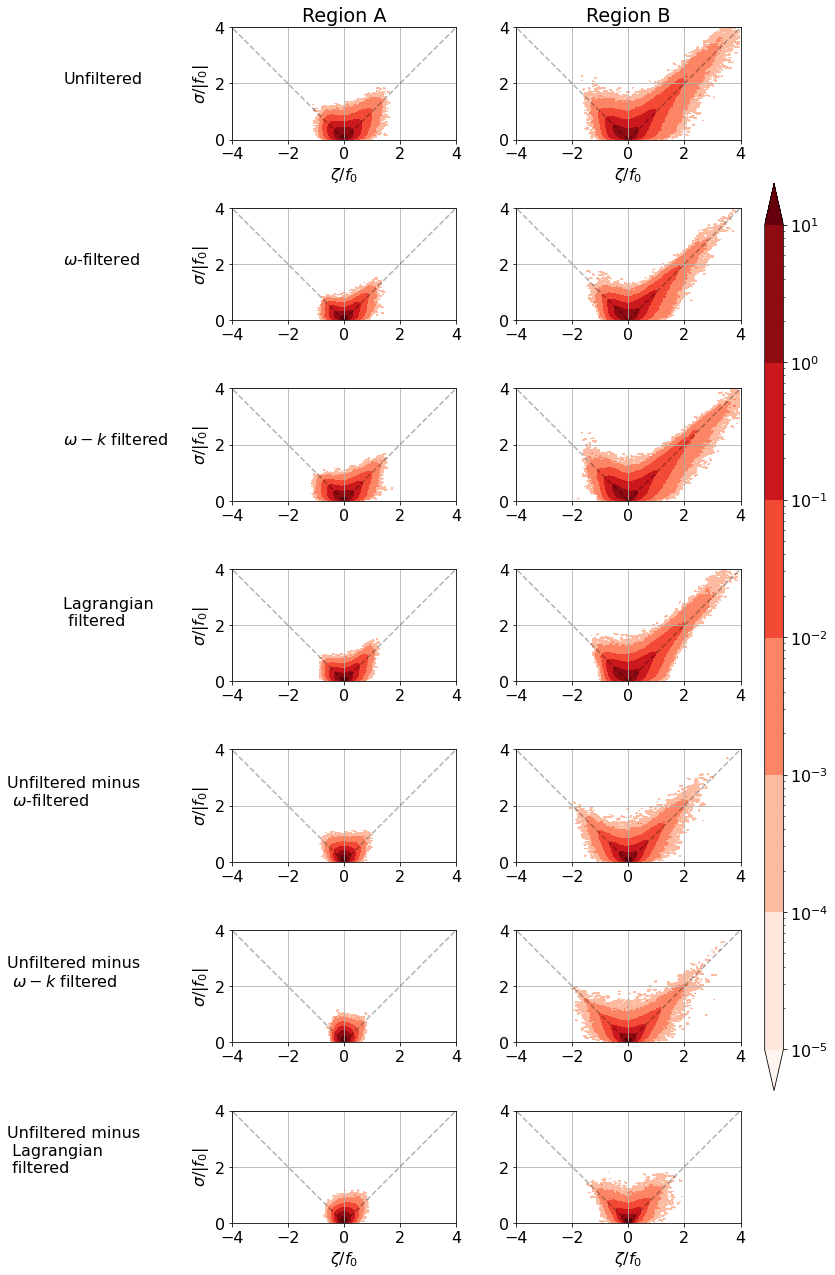

In [18]:
fig, ax = plt.subplots(7,2, figsize=(13,18))

girbNums01 = 320*320

girbNums02 = 312*312


temp20 = (1/(binbox01*girbNums01)*(hist_un_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im00 = ax[0,0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im00, ax=ax[0])
ax[0,0].set_title('Region A')
ax[0,0].set_aspect('equal')
ax[0,0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[0,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0,0].set_xlabel('$\zeta/f_0$')
ax[0,0].set_ylabel('$\sigma/|f_0|$')
ax[0,0].set_ylim(0,4)
ax[0,0].set_xlim(-4,4)
ax[0,0].set_xticks([-4, -2, 0, 2, 4])
ax[0,0].grid()
ax[0,0].text(-10, 2,'Unfiltered',in_layout=True)



temp20 = (1/(binbox01*girbNums01)*(hist_un_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im01 = ax[0,1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im01, ax=ax[1])
ax[0,1].set_title('Region B')
ax[0,1].set_aspect('equal')
ax[0,1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[0,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0,1].set_xlabel('$\zeta/f_0$')
#ax[0,1].set_ylabel('$\sigma/|f_0|$')
ax[0,1].set_ylim(0,4)
ax[0,1].set_xlim(-4,4)
ax[0,1].set_xticks([-4, -2, 0, 2, 4])
ax[0,1].grid()

temp20 = (1/(binbox01*girbNums02)*(hist_eul_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im02 = ax[1,0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im02, ax=ax[0])
#ax[1,0].set_title('vorticity-strain')
ax[1,0].set_aspect('equal')
ax[1,0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[1,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
#ax[1,0].set_xlabel('$\zeta/f_0$')
ax[1,0].set_ylabel('$\sigma/|f_0|$')
ax[1,0].set_ylim(0,4)
ax[1,0].set_xlim(-4,4)
ax[1,0].set_xticks([-4, -2, 0, 2, 4])
ax[1,0].grid()
ax[1,0].text(-10, 2,'$\omega$-filtered ')



temp20 = (1/(binbox01*girbNums01)*(hist_eul_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im03 = ax[1,1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im03, ax=ax[1])
#ax[1,1].set_title('vorticity-strain')
ax[1,1].set_aspect('equal')
ax[1,1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[1,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
#ax[1,1].set_xlabel('$\zeta/f_0$')
#ax[1,1].set_ylabel('$\sigma/|f_0|$')
ax[1,1].set_ylim(0,4)
ax[1,1].set_xlim(-4,4)
ax[1,1].set_xticks([-4, -2, 0, 2, 4])
ax[1,1].grid()

temp20 = (1/(binbox01*girbNums01)*(hist_wfil_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im04 = ax[2,0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im04, ax=ax[0])
#ax[2,0].set_title('vorticity-strain')
ax[2,0].set_aspect('equal')
ax[2,0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[2,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
#ax[2,0].set_xlabel('$\zeta/f_0$')
ax[2,0].set_ylabel('$\sigma/|f_0|$')
ax[2,0].set_ylim(0,4)
ax[2,0].set_xlim(-4,4)
ax[2,0].set_xticks([-4, -2, 0, 2, 4])
ax[2,0].grid()
ax[2,0].text(-10, 2,'$\omega-k$ filtered')


temp20 = (1/(binbox01*girbNums01)*(hist_wfil_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im05 = ax[2,1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im05, ax=ax[1])
#ax[2,1].set_title('vorticity-strain')
ax[2,1].set_aspect('equal')
ax[2,1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[2,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
#ax[2,1].set_xlabel('$\zeta/f_0$')
#ax[2,1].set_ylabel('$\sigma/|f_0|$')
ax[2,1].set_ylim(0,4)
ax[2,1].set_xlim(-4,4)
ax[2,1].set_xticks([-4, -2, 0, 2, 4])
ax[2,1].grid()

temp20 = (1/(binbox01*girbNums01)*(hist_lag_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im06 = ax[3,0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im04, ax=ax[0])
#ax[2,0].set_title('vorticity-strain')
ax[3,0].set_aspect('equal')
ax[3,0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[3,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
#ax[3,0].set_xlabel('$\zeta/f_0$')
ax[3,0].set_ylabel('$\sigma/|f_0|$')
ax[3,0].set_ylim(0,4)
ax[3,0].set_xlim(-4,4)
ax[3,0].set_xticks([-4, -2, 0, 2, 4])
ax[3,0].grid()
ax[3,0].text(-10, 2,'Lagrangian \n filtered')



temp20 = (1/(binbox01*girbNums01)*(hist_lag_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im07 = ax[3,1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im05, ax=ax[1])
#ax[2,1].set_title('vorticity-strain')
ax[3,1].set_aspect('equal')
ax[3,1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[3,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
#ax[3,1].set_xlabel('$\zeta/f_0$')
#ax[3,1].set_ylabel('$\sigma/|f_0|$')
ax[3,1].set_ylim(0,4)
ax[3,1].set_xlim(-4,4)
ax[3,1].set_xticks([-4, -2, 0, 2, 4])
ax[3,1].grid()


temp20 = (1/(binbox01*girbNums01)*(hist_euldiff_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im02 = ax[4,0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im02, ax=ax[0])
#ax[1,0].set_title('vorticity-strain')
ax[4,0].set_aspect('equal')
ax[4,0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[4,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
#ax[4,0].set_xlabel('$\zeta/f_0$')
ax[4,0].set_ylabel('$\sigma/|f_0|$')
ax[4,0].set_ylim(0,4)
ax[4,0].set_xlim(-4,4)
ax[4,0].set_xticks([-4, -2, 0, 2, 4])
ax[4,0].grid()
ax[4,0].text(-12, 2,'Unfiltered minus \n $\omega$-filtered')


temp20 = (1/(binbox01*girbNums01)*(hist_euldiff_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im03 = ax[4,1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im03, ax=ax[1])
#ax[1,1].set_title('vorticity-strain')
ax[4,1].set_aspect('equal')
ax[4,1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[4,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
#ax[4,1].set_xlabel('$\zeta/f_0$')
#ax[4,1].set_ylabel('$\sigma/|f_0|$')
ax[4,1].set_ylim(0,4)
ax[4,1].set_xlim(-4,4)
ax[4,1].set_xticks([-4, -2, 0, 2, 4])
ax[4,1].grid()


temp20 = (1/(binbox01*girbNums02)*(hist_wnl_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im04 = ax[5,0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im04, ax=ax[0])
#ax[2,0].set_title('vorticity-strain')
ax[5,0].set_aspect('equal')
ax[5,0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[5,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
#ax[5,0].set_xlabel('$\zeta/f_0$')
ax[5,0].set_ylabel('$\sigma/|f_0|$')
ax[5,0].set_ylim(0,4)
ax[5,0].set_xlim(-4,4)
ax[5,0].set_xticks([-4, -2, 0, 2, 4])
ax[5,0].grid()
ax[5,0].text(-12, 2,'Unfiltered minus \n $\omega-k$ filtered')


temp20 = (1/(binbox01*girbNums01)*(hist_wnl_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im05 = ax[5,1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im05, ax=ax[1])
#ax[2,1].set_title('vorticity-strain')
ax[5,1].set_aspect('equal')
ax[5,1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[5,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
#ax[5,1].set_xlabel('$\zeta/f_0$')
#ax[5,1].set_ylabel('$\sigma/|f_0|$')
ax[5,1].set_ylim(0,4)
ax[5,1].set_xlim(-4,4)
ax[5,1].set_xticks([-4, -2, 0, 2, 4])
ax[5,1].grid()

temp20 = (1/(binbox01*girbNums01)*(hist_lagdiff_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im02 = ax[6,0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im02, ax=ax[0])
#ax[1,0].set_title('vorticity-strain')
ax[6,0].set_aspect('equal')
ax[6,0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[6,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[6,0].set_xlabel('$\zeta/f_0$')
ax[6,0].set_ylabel('$\sigma/|f_0|$')
ax[6,0].set_ylim(0,4)
ax[6,0].set_xlim(-4,4)
ax[6,0].set_xticks([-4, -2, 0, 2, 4])
ax[6,0].grid()
ax[6,0].text(-12, 1.8,'Unfiltered minus \n Lagrangian \n filtered')


temp20 = (1/(binbox01*girbNums01)*(hist_lagdiff_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im03 = ax[6,1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

#h00 = fig.colorbar(im03, ax=ax[1])
#ax[1,1].set_title('vorticity-strain')
ax[6,1].set_aspect('equal')
ax[6,1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[6,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[6,1].set_xlabel('$\zeta/f_0$')
#ax[6,1].set_ylabel('$\sigma/|f_0|$')
ax[6,1].set_ylim(0,4)
ax[6,1].set_xlim(-4,4)
ax[6,1].set_xticks([-4, -2, 0, 2, 4])
ax[6,1].grid()

plt.tight_layout()

plt.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im03, cax=cbar_ax)



fig.savefig('JPDF-spencer.png')